In [199]:
import numpy as np
import scipy
import scipy.stats
import scipy.sparse
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.neighbors import NearestNeighbors
import time
import os
import json
from datetime import datetime
import matplotlib
matplotlib.use('PS')
import matplotlib.pyplot as plt
%matplotlib inline
import scanpy as sc
import pandas as pd
from distutils.version import LooseVersion, StrictVersion
from collections import Counter
import seaborn as sns

# Load data

In [200]:
data_dir = './Data/'
plot_dir = './Plots/'
data = pd.read_csv(data_dir+'hwf_clean_2020-05-12.csv', dtype=str)
data.shape

(3661716, 186)

### Key stats 05-07

In [ ]:
# 3,047,612 responses
# 186 features
# 489,241 unique users
# 9,174 users tested (1,547 antibody tests + 4,956 swab tests + tests of unknown type (presumable swab): a few tested multiple ways)
    # 6,479 users negative
    # 982 users positive

### Subset users with swab qPCR test (v4) or assumed swab qPCR test (v1-3)

In [201]:
tmp = data.query("survey_version!='4'")
pre_v4_tested_users = np.unique(tmp['session_id'][tmp.covid_19_test_result.isin(["positive","negative"])]) # 2685
v4_tested_users = np.unique(data['session_id'][data.covid_19_swab_test_result.isin(["positive","negative"])]) # 4334
tested_users = np.unique(list(pre_v4_tested_users) + list(v4_tested_users))
data = data[data.session_id.isin(tested_users)]
print(f"Subset data to {len(tested_users)} qPCR tested users including a total of {data.shape[0]} responses")


Subset data to 8396 qPCR tested users including a total of 77632 responses


### Convert to boolean

In [202]:
data.replace(to_replace='True', value=True, inplace=True, regex=True)
data.replace(to_replace='False', value=False, inplace=True, regex=True)

# Merge symptoms asked in all surveys into interpretable list

### Symptom variables available across all surveys

In [203]:
symptoms = ['not_well_symptoms_chills_shaking',
    'not_well_symptoms_diarrhea',
    'not_well_symptoms_dry_cough',
    'not_well_symptoms_fever',
    'not_well_symptoms_loss_of_appetite',
    'not_well_symptoms_loss_of_taste_and_or_smell',
    'not_well_symptoms_muscle_and_joint_pain',
    'not_well_symptoms_nasal_congestion',
    'not_well_symptoms_nausea_and_vomiting',
    'not_well_symptoms_runny_nose',
    'not_well_symptoms_shortness_of_breath',
    'not_well_symptoms_sore_throat',
    'not_well_symptoms_tight_feeling_in_chest',
    'not_well_symptoms_wet_cough',
    'symptoms_well_chills',
    'symptoms_well_cough',
    'symptoms_well_headache',
    'symptoms_well_loss_of_taste_and_or_smell',
    'symptoms_well_low_grade_fever',
    'symptoms_well_mild_fatigue',
    'symptoms_well_muscle_and_joint_pain',
    'symptoms_well_nasal_congestion',
    'symptoms_well_runny_nose',
    'symptoms_well_tight_feeling_in_chest']
    

### Merge symptoms into interpretable bins

In [309]:
data['nausea_and_vomiting'] = data['not_well_symptoms_nausea_and_vomiting']
data['diarrhea'] = data['not_well_symptoms_diarrhea']
data['dry_cough'] = data['not_well_symptoms_dry_cough']
data['wet_cough'] = data['not_well_symptoms_wet_cough']
data['mild_cough'] = data['symptoms_well_cough']
data['nasal_congestion'] = np.logical_or(data['not_well_symptoms_nasal_congestion'].values, data['symptoms_well_nasal_congestion'].values)
data['runny_nose'] = np.logical_or(data['not_well_symptoms_runny_nose'].values, data['symptoms_well_runny_nose'].values)
data['sore_throat'] = data['not_well_symptoms_sore_throat']
data['fever'] = np.logical_or(data['not_well_symptoms_fever'].values, data['symptoms_well_low_grade_fever'].values)
data['chills_shaking'] = np.logical_or(data['not_well_symptoms_chills_shaking'].values, data['symptoms_well_chills'].values)
data['muscle_and_joint_pain'] = np.logical_or(data['not_well_symptoms_muscle_and_joint_pain'].values, data['symptoms_well_muscle_and_joint_pain'].values)
data['loss_of_appetite'] = data['not_well_symptoms_loss_of_appetite']
data['loss_of_taste_and_or_smell'] = np.logical_or(data['not_well_symptoms_loss_of_taste_and_or_smell'].values, data['symptoms_well_loss_of_taste_and_or_smell'].values)
data['shortness_of_breath'] = data['not_well_symptoms_shortness_of_breath']
data['tight_feeling_in_chest'] = np.logical_or(data['not_well_symptoms_tight_feeling_in_chest'].values, data['symptoms_well_tight_feeling_in_chest'].values)
data['mild_headache'] = data['symptoms_well_headache']
data['mild_fatigue'] = data['symptoms_well_mild_fatigue']

symptoms = ['runny_nose',
            'sore_throat',
            'dry_cough',
            'muscle_and_joint_pain',
            'nasal_congestion',
            'loss_of_taste_and_or_smell',
            'tight_feeling_in_chest',
            'shortness_of_breath',
            'loss_of_appetite',
            'fever',
            'chills_shaking',
            'diarrhea',
            'nausea_and_vomiting',
            'wet_cough',
            'mild_cough',      
            'mild_fatigue',
            'mild_headache']

# Histogram of symptom reporting

In [304]:
plt.rcParams.update(plt.rcParamsDefault)
#plt.style.use('classic')

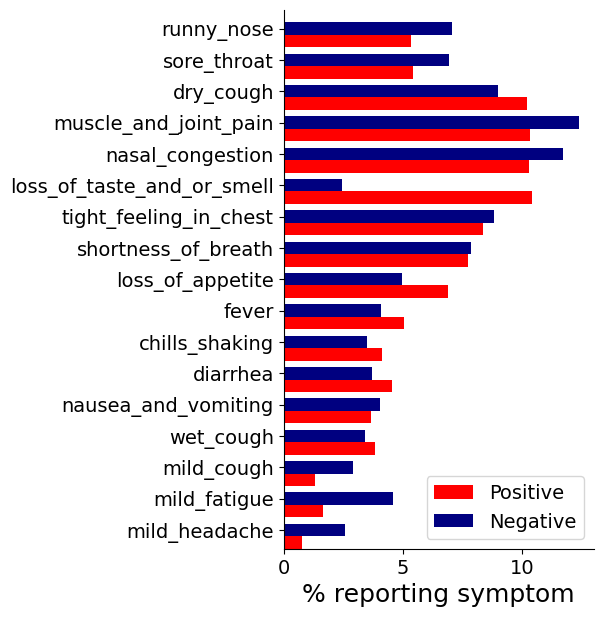

In [305]:
symptoms = [
    'mild_headache',
    'mild_fatigue',
    'mild_cough',
    'wet_cough',
    'nausea_and_vomiting',
    'diarrhea',
    'chills_shaking',
    'fever',
    'loss_of_appetite',
    'shortness_of_breath',
    'tight_feeling_in_chest',
    'loss_of_taste_and_or_smell',
    'nasal_congestion',
    'muscle_and_joint_pain',
    'dry_cough',
    'sore_throat',
    'runny_nose'
]

pos_users = data[np.logical_or(list(data.covid_19_test_result=='positive'),list(data.covid_19_swab_test_result=='positive'))]
neg_users = data[np.logical_or(list(data.covid_19_test_result=='negative'),list(data.covid_19_swab_test_result=='negative'))]
pos_sympts = pos_users[symptoms].sum(0)
pos_sympts /= pos_sympts.sum()
pos_sympts *= 100
neg_sympts = neg_users[symptoms].sum(0)
neg_sympts /= neg_sympts.sum()
neg_sympts *= 100
#pd.DataFrame({'pos':pos_sympts, 'neg': neg_sympts}).plot(kind='bar', figsize=(10,5))

#df = pandas.DataFrame(dict(graph=['Item one', 'Item two', 'Item three'],
#                           n=[3, 5, 2], m=[6, 1, 3])) 

df = pd.DataFrame({'pos':pos_sympts, 'neg': neg_sympts}) 

ind = np.arange(len(df))
width = 0.4

fig, ax = plt.subplots(figsize=(4,7))
plt.barh(ind, df.pos, width, color='red', label='Positive')
plt.barh(ind + width, df.neg, width, color='navy', label='Negative')
ax.set(yticks=ind + width, yticklabels=symptoms, ylim=[2*width - 1, len(df)])
ax.legend(loc='lower right',prop={'size': 14})
plt.xlabel('% reporting symptom', size=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(plot_dir+"symptom_histogram.pdf",dpi=200,bbox_inches='tight')

In [336]:
len(neg_users.session_id.unique())

7362

# Symptom timeseries heatmaps

### Histogram of session numbers for all versus tested users

In [ ]:
plt.rcParams['ps.useafm'] = True
#plt.rcParams.update(plt.rcParamsDefault)

In [330]:
np.array([session_counts[k] for k in session_counts]).mean()

9.246307765602667

In [331]:
max(x)

39

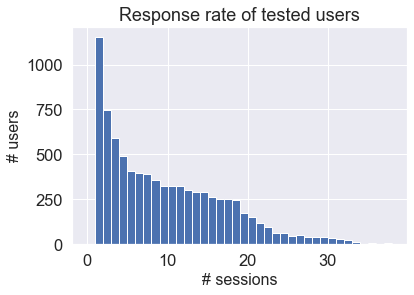

In [325]:

# Histogram of records per user
session_counts = Counter(data['session_id'])
x = session_counts.values()
total_users = sum(x)

%matplotlib inline
plt.hist(x ,range(max(x)))
plt.title('Response rate of tested users', size=18)
plt.xlabel('# sessions', size=16)
plt.ylabel('# users', size=16)
plt.show()

### Histogram of aggregate temporal information

In [314]:
# Histogram of session times versus COVID-19 test
users = np.unique(data['session_id'])
delta_test_dates = []

for user in users:

    responses = data[data['session_id']==user]

    # get date of first test
    test_idx = np.logical_or(responses['covid_19_test_tested']==True, responses['covid_19_swab_test_tested']==True)
    date_idx = responses['date'][test_idx].first_valid_index()
    first_test = datetime.strptime(responses['date'][date_idx], "%Y-%m-%d %H:%M:%S")

    # calculate delta to first test of all responses
    dates = list(responses['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")))
    x = [date-first_test for date in dates]
    delta_test_dates += [val.days for val in x]
    

In [322]:
sum(np.array(delta_test_dates)==7)

1844

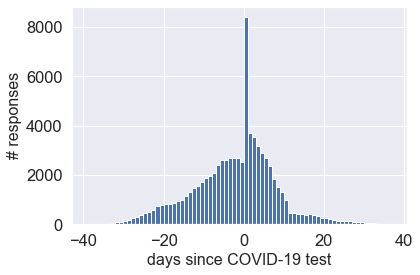

In [208]:
plt.hist(delta_test_dates, range(min(delta_test_dates), max(delta_test_dates)))
#plt.title('COVID19-tested users', size=18)
plt.xlabel('days since COVID-19 test', size=16)
plt.ylabel('# responses', size=16)
plt.show()

## Plot heatmap of symptoms over time for tested users

In [209]:
def get_delta_test_dates(data): # updated 05-12, now compatible with multiple different surveys
    """
    Takes a user slice of data as input and returns the time from each response to the first test of that user. 
    """
    data = data.reset_index()
    
    test_dates = []

    for i, row in data.iterrows():
        if row['survey_version']=='4':
            if type(row['covid_19_swab_test_date'])==str:
                test_dates.append(datetime.strptime(row['covid_19_swab_test_date'], "%Y-%m-%d"))
        else:
            if type(row['covid_19_test_date'])==str:
                test_dates.append(datetime.strptime(row['covid_19_test_date'], "%Y-%m-%d"))
    try:
        first_test = min(test_dates)
    except:
        print(f"Warning: user {data['session_id'].iloc[0]} has no reported test date, using first response date")
        first_test = datetime.strptime(data['date'].iloc[0], "%Y-%m-%d %H:%M:%S")
        
    dates = list(data['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")))
    x = [date-first_test for date in dates]
    delta_test_dates = [val.days for val in x]
    
    return delta_test_dates

### Calculate time relative to test for each response

In [210]:
# Add datafield for days since COVID-19 test
tmp = data[data['covid_19_test_tested'] == True]
users = np.unique(tmp['session_id'])
tmp = data.set_index('session_id')
data_tested = tmp.loc[users]
data_tested_grouped = data_tested.groupby('session_id')

delta_test_dates = []
for user, user_data in data_tested_grouped:
    delta_test_dates += get_delta_test_dates(user_data)
data_tested['delta_test_dates'] = delta_test_dates  

# Parse tested data into positive and negative test results



### Calculate fraction of users reporting each symptom over time

In [211]:
def get_symptom_map(data, symptoms):
    """
    Takes dataframe with 'delta_test_dates' field and generates a symptom map.
    """
    # Group dataframe by delta_test_dates
    data_grouped = data.groupby('delta_test_dates')

    # For each date, compute the fraction of users experiencing each symptom
    symptom_map = np.zeros((len(symptoms), max(data['delta_test_dates'])-min(data['delta_test_dates'])+1))
    x_ticks = [int(i) for i in range(min(data['delta_test_dates']),max(data['delta_test_dates'])+1)]

    for j, delta_data in data_grouped:

        col = x_ticks.index(int(j))
        num_responses = delta_data.shape[0]

        for row,symptom in enumerate(symptoms):

            symptom_map[row,col] = sum(delta_data[symptom]==True)/num_responses
    
    return symptom_map, x_ticks

In [310]:
# Symptom map for positive tested users
positive_users = data_tested[data_tested['covid_19_test_result'] == 'positive'].index.unique() # n=982
data_tested_positive = data_tested.loc[positive_users]
symptom_map_pos, dates_pos = get_symptom_map(data_tested_positive, symptoms)

# Symptom map for negative tested users
negative_users = data_tested[data_tested['covid_19_test_result'] == 'negative'].index.unique() # n=6,479
data_tested_negative = data_tested.loc[negative_users]
symptom_map_neg, dates_neg = get_symptom_map(data_tested_negative, symptoms)

### Plot symptom map

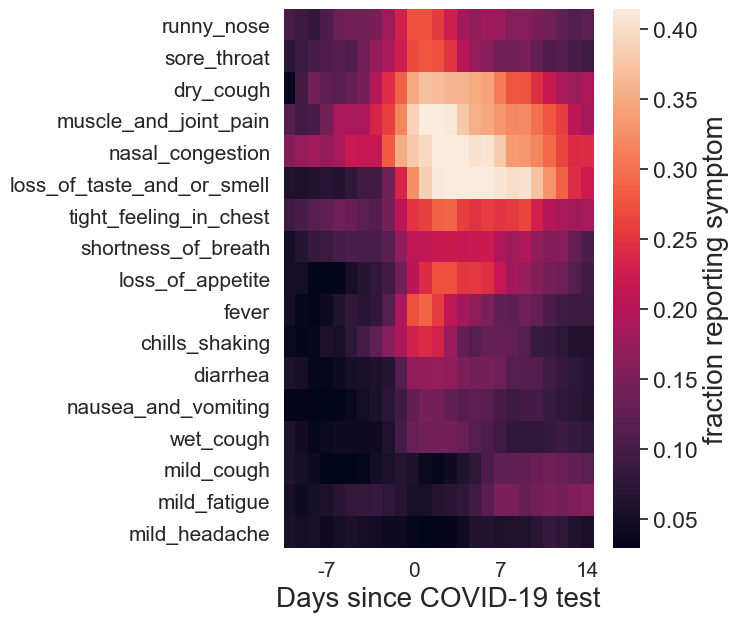

In [311]:
# Specify inputs
plot_dates = dates_pos
plot_map = symptom_map_pos
min_date = -10
max_date = 14
smooth_plot = True

# Adjust date range
idx = [plot_dates.index(date) for date in plot_dates if (date>min_date-1) & (date<max_date+1)]
plot_dates = [plot_dates[i] for i in idx]
plot_map = plot_map[:,idx]

if smooth_plot:
    for i in range(plot_map.shape[0]):
        for j in range(plot_map.shape[1]):
            if j==0:
                plot_map[i,j] = np.mean([plot_map[i,j], plot_map[i,j+1]])
            elif j==24:
                plot_map[i,j] = np.mean([plot_map[i,j-1], plot_map[i,j]])
            else:
                plot_map[i,j] = np.mean([plot_map[i,j-1], plot_map[i,j], plot_map[i,j+1]])

  
# Plot results heatmap (rows = symptoms, cols = day)
xtick_labels = ['','','','-7','','','','','','','0','','','','','','','7','','','','','','','14']
fig, ax = plt.subplots(figsize=(5,7))
sns.set(font_scale=1.5)
sns.heatmap(plot_map, linewidth=0, robust=True, yticklabels=symptoms, xticklabels=xtick_labels, 
            cbar_kws={'label': "fraction reporting symptom"})
ax.figure.axes[-1].yaxis.label.set_size(20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Days since COVID-19 test', size=20)
plt.savefig(plot_dir+"symptom_heatmap.pdf",dpi=200,bbox_inches='tight')

### Plots odds ratio of symptom dynamics

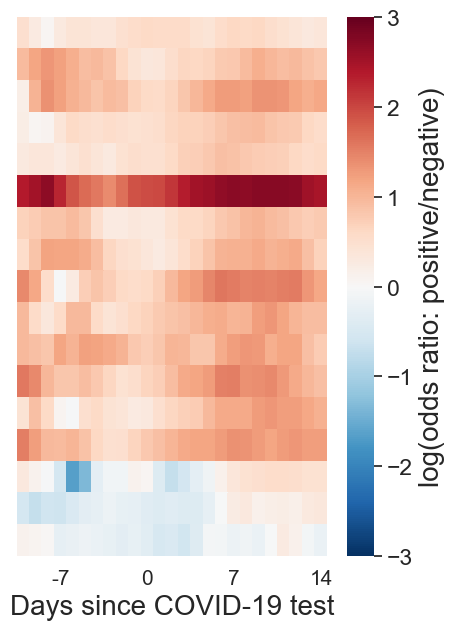

In [312]:
def get_symptom_map_odds_ratio(data1, data2, symptoms, smooth):
    """
    Takes two slices of survey data as input and plots a heatmap of symptom odds ratio over time.
    """
    map1, dates1 = get_symptom_map(data1, symptoms)
    map2, dates2 = get_symptom_map(data2, symptoms)
    
    x1 = np.array([int(date) for date in dates1])
    x2 = np.array([int(date) for date in dates2])
    
    map1_use = map1[:,(-11<x1) & (x1<15)] 
    map2_use = map2[:,(-11<x2) & (x2<15)] 
    
    if smooth:
        
        map1_use_orig = map1_use
        map2_use_orig = map2_use
        
        for i in range(map1_use.shape[0]):
            for j in range(map1_use.shape[1]):
                
                if j==0:
                    map1_use[i,j] = np.mean([map1_use_orig[i,j], map1_use_orig[i,j+1]])
                    map2_use[i,j] = np.mean([map2_use_orig[i,j], map2_use_orig[i,j+1]])
                elif j==24:
                    map1_use[i,j] = np.mean([map1_use_orig[i,j-1], map1_use_orig[i,j]])
                    map2_use[i,j] = np.mean([map2_use_orig[i,j-1], map2_use_orig[i,j]])
                else:
                    map1_use[i,j] = np.mean([map1_use_orig[i,j-1], map1_use_orig[i,j], map1_use_orig[i,j+1]])
                    map2_use[i,j] = np.mean([map2_use_orig[i,j-1], map2_use_orig[i,j], map2_use_orig[i,j+1]])
                    
        
    symptom_odds = map1_use/map2_use
    dates = list(range(-10,15))
    
    return symptom_odds, dates
    

# Get odds ratio
symptom_odds, dates = get_symptom_map_odds_ratio(data_tested_positive, data_tested_negative, symptoms, smooth=True)

# Plot ratio of symptoms for those that test positive versus test negative
fig, ax = plt.subplots(figsize=(5,7))
xtick_labels = ['','','','-7','','','','','','','0','','','','','','','7','','','','','','','14']
sns.set(font_scale=1.5)
sns.heatmap(np.log(symptom_odds), linewidth=0, robust=True,
            cmap='RdBu_r', center=0, vmax=3, vmin=-3,
            xticklabels=xtick_labels, yticklabels=[], 
            cbar_kws={'label': "log(odds ratio: positive/negative)"}) #PRGn
plt.tick_params(axis='y', which='both', left=False)
ax.figure.axes[-1].yaxis.label.set_size(20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Days since COVID-19 test', size=20)
plt.savefig(plot_dir+"symptom_odds_ratio.pdf",dpi=200,bbox_inches='tight')